#Metric Learning

##When two image are similar ?



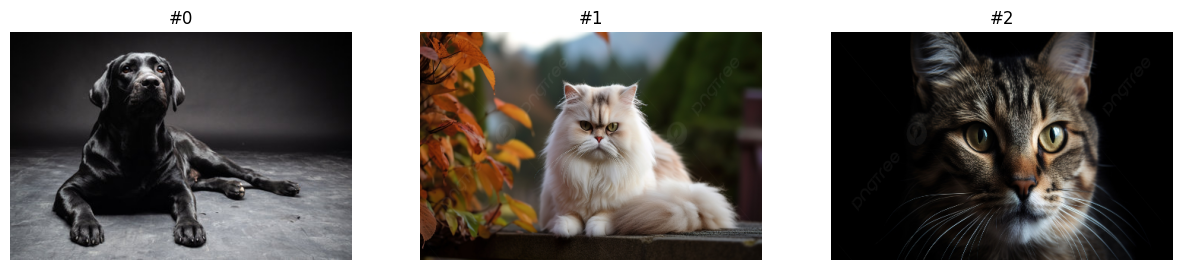

In [156]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import backend as K


codes=[ '1igH62U1vMRrajeVAegZ5-3gsINmA-5x1 ', '10Q3CYRW4hpcuuZec5eOuXvwQ8OD8OZ7j','11BFlXWR5PfGYYlmTOJ0l_Cz3doDWtd8K' ]
img_shape = (450,300,3)

# codes=['1f-tn7K_q2Qvtxeh3C27MQPIh6uEzoVQZ','1e448rCVsEJ1jGsk2MyoReeecIHCWWkMe', "1GSWnue00CcWETZ0_5vEGY7nCIDNWIEad","106hzZt6Vz49DXuKPt-K-ZzoKgR4_GZ4m"]
# img_shape = (224,224,3)


images=[]
for c in codes :
  url="https://drive.google.com/uc?id="
  img = imageio.imread(url+c)
  img = cv2.resize(img, (img_shape[0],img_shape[1]))
  images.append(img)


def plot_images():
  fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
  for idx, (ax, img) in enumerate( zip(axes, images) ):
      ax.set_title(f'#{idx}')
      ax.imshow(img)
      ax.axis('off')

  plt.show()

plot_images()

Distance Matrix:
 [[1.         1.         0.09164846]
 [1.         1.         0.99625992]
 [0.09164846 0.99625992 1.        ]]

Most similar index:
 [2 2 0]


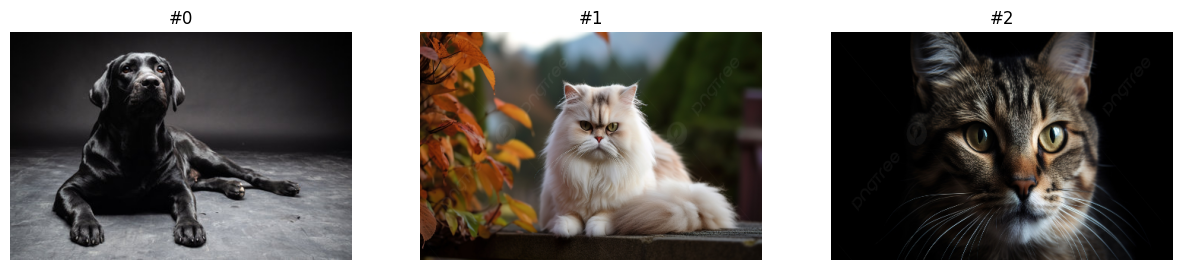

In [157]:
from sklearn.metrics import pairwise_distances

def norm_euclid( x, eps=1e-10 ):
  dist =np.sqrt(((x[:, np.newaxis] - x) ** 2).sum(axis=2))
  norm_dist = dist / (np.max(dist) + eps)
  return norm_dist


imgs = np.array(images) //255
x = np.array([xx.flatten() for xx in imgs])

dists=norm_euclid(x) #error at index 1
np.fill_diagonal(dists, 1.0 )
similarities = np.argmin(dists, axis=1)

print( "Distance Matrix:\n",dists )
print( "\nMost similar index:\n",similarities )
plot_images()

Problem: How can we cluster images according to their content?
Background can influence the classification. If we want to base the similarity on the image content, we need somenting more powerfull.

**Embeddings can solve our problem.**

The numerical vector representation of images, words, senteces, or even music is commonly called **embeddings** and the multidimensinal space where embeddings lies is called **embedding space.**

In this space, the distance or direction of the feature vectors reflects the semantic relations between two entities.

For the purpose of our example, we want to compute embeddings that represent the visual content of the image.

Actually when we build a classifier, we train the network to identify the content of the images.




What if we want to do the same thing with another class ?

Do we need to train again the model?
And what if we lack sufficient images for training and testing?

We can see he problem as
**Let's use transfert learning**:
we can apply ResNet50 as backbone by removing its last layer.

embedding size: (None, 2048)
Distance Matrix:
 [[1.         0.9573897  0.84007937]
 [0.9573897  1.         1.        ]
 [0.84007937 1.         1.        ]]
Similarities (minimum):
 [2 0 0]


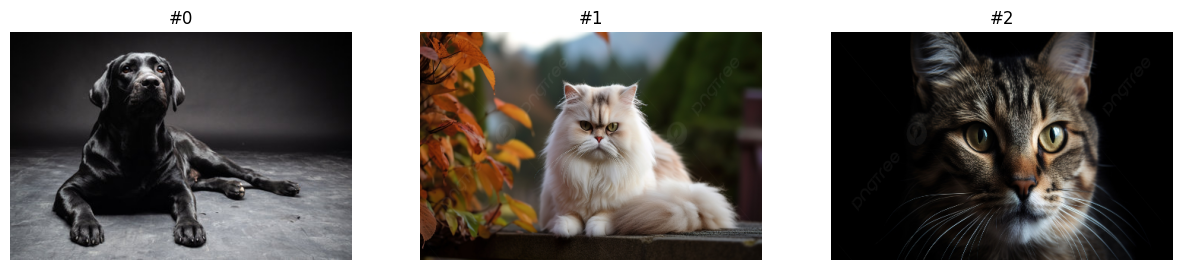

In [158]:
from keras.applications import ResNet50V2
from keras.models import Model


h = img_shape[1]
w = img_shape[0]
c = img_shape[2]

feat_extractor = ResNet50V2(weights='imagenet', include_top=False, pooling="avg",  input_shape=(h,w,c))

print( "embedding size:",feat_extractor.output.shape)

model = Model(inputs=feat_extractor.input, outputs=feat_extractor.output)
#compute embeddigns
embs = model( imgs ).numpy()
dists = norm_euclid( embs )
np.fill_diagonal(dists, 1.0 )
similarities = np.argmin( dists, axis=-1)


print( "Distance Matrix:\n",dists )
print( "Similarities (minimum):\n",similarities )
plot_images()

what if we change images ?

##Embedding Space Organization



How actually crossentropy shapes the embedding spaces for MNIST was showed in https://arxiv.org/pdf/1712.10151.

![Softmax Embs](https://drive.google.com/uc?id=1fDEfcjfFtzUJ98cZbJ6g3HyxJItLYPVm )


Distance Matrix:
 [[0.         0.86664665 0.9069259 ]
 [0.86664665 0.         0.8691141 ]
 [0.9069259  0.8691141  0.        ]]
Similar (max):
 [2 2 0]


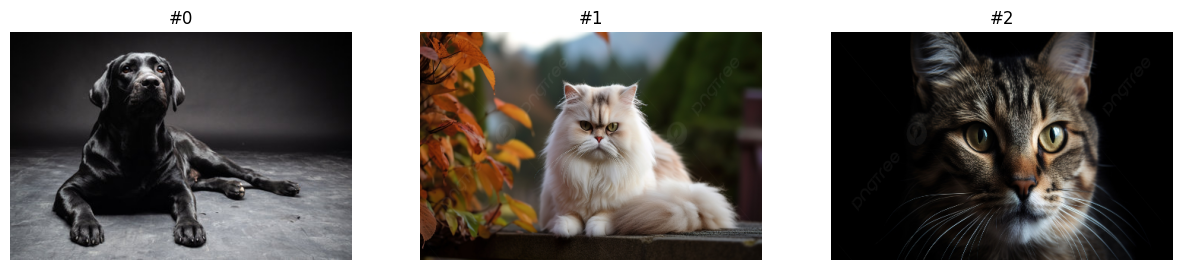

In [159]:
from sklearn.metrics.pairwise import cosine_similarity

# norm_embs = np.sqrt(np.sum(embs**2, axis=1, keepdims=True))  #l2 normalization

dist_mat = cosine_similarity(embs,embs)
np.fill_diagonal(dist_mat, 0)

top_similar = np.argmax( dist_mat, axis=1)

print( "Distance Matrix:\n",dist_mat )
print( "Similar (max):\n",top_similar )
plot_images()

When we change distribution the background can still influence the classification. Now immagine if we open the problem towards a new class. We should retrain the network every time.

So what is a good embedding ? which caractheristic the embedding should have ?


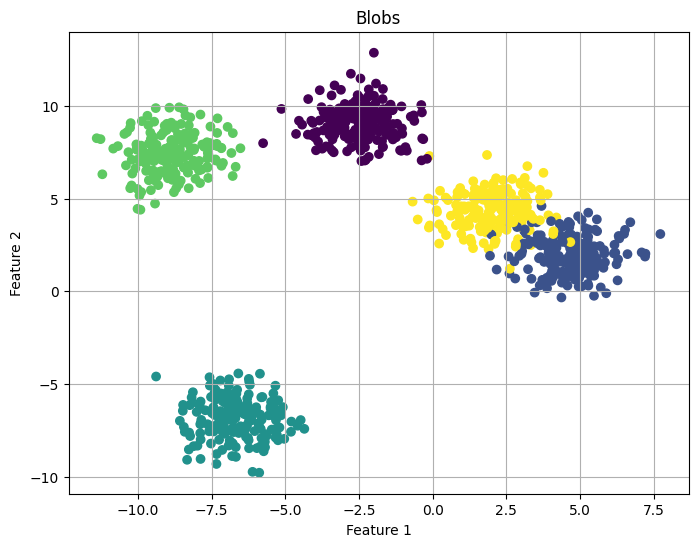

In [139]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=5, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

##Change now the perspective of the problem as verification problem.

If two images depitch the same "instance" then they are similar and they have a similar embedding. Otherwise the two immages are different.

If the embedding space is large enough for deptching a new class and I have enough training data, even for different instances, the network would be able to generalize better for the new examples.


##Metric Learning

The main idea of metric learning is of using a loss at training time for drive the feature extractor network towards a better and more discriminative reppresentation of embeddings where the intra-class distance (similarity distances between same classes) is minimize and at the same time the inter-class distance (similarity distances between different classes) is maximized.




In [149]:
#Contrastive loss
#Used to push far away or closer the embeddings
def contrastive_loss(embs1,embs2, label1, label2, dist_fun, m=0.1 ):

  same = K.cast(label1==label2, dtype=tf.float32)
  dist= dist_fun(embs1,embs2)

  loss = same*(dist+m) + (1-same) * K.max(0,dist+m)

  return K.mean(loss, axis=0)

The margin **m** is important:

*   Positive cases: marging prevents that embeddings converge to the same point
*   Negative cases: avoid pushing different embeddings far. In the practice it does not take any practival advantages.


In [150]:
#Triplet Loss
#A generalization of the problem from verification to triplets (ancor, positive, negatives)
# Formula is dist_ap + α < dist_an
def triplet_loss( anchors, positives, negatives, dist_fun, margin=0.1):

  dist_ap = dist_fun(anchors, positives)
  dist_an = dist_fun(anchors, negatives)

  loss = K.maximum(0.0, (dist_ap-dist_an)+margin)
  return K.mean(loss, axis=0)


The **semi-hard triplet sampling strategy** was proven to be effective.
First sample C*K images from the dataset. Then,pick the hardest positive (very different) and the hardest negative (very similar) of the batch.



Another version of triplet loss is done in this way


```
y = K.ones(shape=K.shape(dist_an))
loss = K.max( 0.0, -y* ( dist_ap - dist_an)+margin)
return K.mean(loss, axis=0)

```


##Modern Embedding shaping


*   Classification with softmax becomes a better pre-training objective, but clusters are not well separated.

*   During training, the output embedding is normalized by dividing it for its l2 norm, so the values are inside an hypersphere.

*   As a consequence we can use an angular similarity function like cosine similarity function for computing the similarity among embeddings.


ArcFace loss introduce un margine angolare additivo nella funzione di perdita softmax. Il margine angolare additivo è un parametro che controlla la separabilità tra le classi. Un valore di margine più alto porta a una maggiore separabilità tra le classi.

https://arxiv.org/pdf/1801.07698

In [151]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform


#ArcFace Loss
class ArcFace(tf.keras.losses.Loss):

  def __init__(self, num_classes, emb_dim, margin=0.5, scale=0.64, eps=K.epsilon() ):
    super().__init__()
    self.weights = tf.Variable(glorot_uniform(shape=(num_classes, emb_dim)), dtype=tf.float32)
    self.margin = margin
    self.scale = scale
    self.eps = eps


  def call(self, embs, labels):
    # Normalize feature vectors to compare
    embs_norm = tf.nn.l2_normalize(embs, axis=1)
    norm_weight = tf.nn.l2_normalize( self.weights, axis=0)
    w_label = tf.gather(norm_weight, label, axis=1)

    #Cosine similarity between features and weights
    cosine_sim = tf.matmul(embs_norm, tf.transpose(w_label) )
    cosine_sim = tf.clip_by_value(cosine_sim, -1.0+eps, 1.0-eps)

    theta = tf.acos(cosine_sim)
    probs = s * tf.math.cos(theta + m) #multiply by s project into the axis space of the sphere

    # One-hot encode the labels
    one_hot = tf.one_hot(tf.cast(label, tf.int32), depth=num_classes) #may have the label smoothing
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot, logits=probs )

    return tf.reduce_mean(loss)

##eventually think about using label smoothing on cross entropy

We can obtain a loss considering all negatives in a batch by computing the cross-entropy loss of the softmax of the cosine similarities between the anchor and all the other samples, where the positive sample acts as the positive class.

To make the loss focus on a larger set of negatives we can reduce the differences between the cosine similarities using a temperature τ. In this case we obtained the so-called normalized temperature-scaled cross entropy loss. It is the NT-Xent loss

In [152]:
#Xent loss
def nt_xent_loss(tau):
  #tau is the value of the temperature, it can be a scheduler

  def loss(label, embs ):
    # Normalize embeddings
    embs = tf.math.l2_normalize(embs, axis=1)

    # Compute cosine similarity matrix
    cosine_sim = tf.matmul(embs, embs, transpose_b=True)

    # Exclude diagonal from similarity matrix (similarity of each embedding with itself)
    mask = tf.eye(cosine_sim.shape[0]) * -np.inf
    cosine_sim = cosine_sim + mask

    # Scale cosine similarities by temperature
    #By dividing by temperature τ the cosine similarities we can focus on a larger set.
    cosine_sim = cosine_sim / tau

    # Compute cross-entropy loss using TensorFlow's built-in function
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=cosine_sim, labels=labels)
    return tf.reduce_mean(loss)

  return loss


In a batch all the samples are from different classes.
Paper: https://papers.nips.cc/paper_files/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html

##Connecting the dots



*   Metric Learning and Cross entropy can be trained jointly
*   Such techniques can be used in several open world problems:


    *   We don't know how to actually quantitatively measure the identity preservation.
    *   Few shot learning
    *   Re-identification
    *   Fine-grained content-based image retrieval (CBIR)
    


##Clip
this work has more than 16K citations
https://arxiv.org/abs/2103.00020



![Clip](https://drive.google.com/uc?id=1t2AxYXof5sgCEAD8BmJ517BhoOPdhErF )



Understainding Clip

![Clip](https://drive.google.com/uc?id=1LM9jZ2q1oiUYMhCej5rWJegmSQrSQpMx )

In [ ]:
# Numpy-like pseudocode for the core of an implementation of CLIP


# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter

# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]

# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)

# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)

# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2


In [ ]:
from transformers import TFCLIPModel, CLIPProcessor

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/606M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

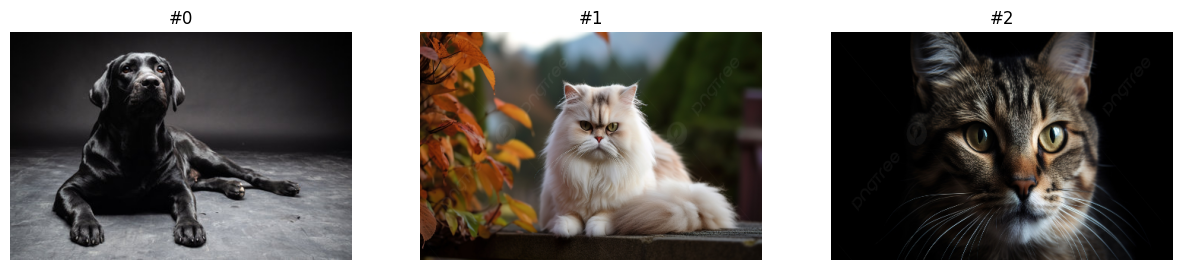

In [ ]:
 ##let's try again with the photo of before
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for idx, (ax, img) in enumerate( zip(axes, images) ):
    ax.set_title(f'#{idx}')
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [ ]:

text_queries = ["A photo of a white cat","A photo of a brown cat","A photo of a dog"]
gallery_images = np.array(images)
inputs = processor( text=text_queries, images=gallery_images,padding=True, return_tensors="tf")
outputs = model(**inputs)

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


In [ ]:
import tensorflow as tf
logits_per_text = outputs.logits_per_text  # this is the text-image similarity score
probs = tf.nn.softmax(logits_per_text, axis=1)


for i,q in enumerate( text_queries):
  print("\n")
  print(f"Query: '{q}'")
  print(f"Probability scores: { np.round( probs.numpy()[i],4) }")




Query: 'A photo of a white cat'
Probability scores: [0.     0.9898 0.0102]


Query: 'A photo of a brown cat'
Probability scores: [0.     0.2445 0.7554]


Query: 'A photo of a dog'
Probability scores: [0.9803 0.0077 0.012 ]
